In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import qutip
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems
from CoupledQuantumSystems.IFQ import gfIFQ
import scqubits

In [4]:
def visualize_c_ops(c_ops,evals):
    level_to_x = {
        0:1,
        1:0,
        2:2,
        3:1,
        4:0,
        5:1,
        6:2,
        7:-1.5,
        8:-0.5,
        9:0.5,
        10:1.5,
        11:2.5,
        12:3.5,
        13:-0.5,
        14:1.5,
        15:2.5,
        16:3.5,
        17:4.5,
        18:5.5,
        19:6.5,

    }
    def plot_levels(ax):
        for ql,eval in enumerate(evals):
            eval_with_2pi = 2*np.pi*eval
            x = level_to_x[ql]
            length = 0.3
            ax.plot([x-length,x+length], [eval_with_2pi,eval_with_2pi])
            ax.text(x,eval_with_2pi-3,f"{ql}",va='center',ha='center',fontsize=10)
    def plot_thermalization(ax):
        max_element = np.max(np.abs(np.square((c_ops.full()))))
        max_lw = 4
        lw_scaling_ratio = max_lw/max_element
        decay_color = '#4999c3'
        heating_color = '#d5373d'
        for i in range(len(evals)):
            for j in range(len(evals)):
                if i == j:
                    continue
                else:
                    i_y = 2*np.pi*evals[i]
                    j_y = 2*np.pi*evals[j]
                    i_x = level_to_x[i]
                    j_x = level_to_x[j]
                    lw = lw_scaling_ratio* np.abs(np.square((c_ops[i,j])))
                    if lw > 0.01:
                        if i < j:
                            ax.plot([i_x+0.1,j_x+0.1], [i_y,j_y], color = decay_color , lw = lw )
                        else:
                            ax.plot([i_x-0.1,j_x-0.1], [i_y,j_y], color = heating_color , lw = lw )
                if i == j-1:
                    i_y = 2*np.pi*evals[i]
                    j_y = 2*np.pi*evals[j]
                    i_x = level_to_x[i]
                    j_x = level_to_x[j]
                    ax.text((i_x+j_x)/2, (i_y+j_y)/2, f'{evals[j]-evals[i]:.2f}',va='center',ha='center',size = 6 )
    fig, ax = plt.subplots(1,1,figsize = (5,5))
    plot_levels(ax)
    plot_thermalization(ax)
    return fig,ax

Text(0.5, 0, '$\\phi/2\\pi$')

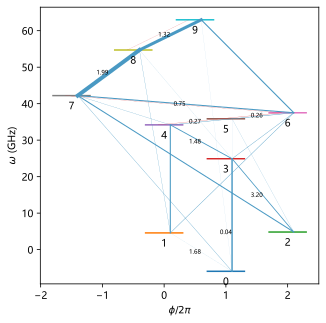

In [5]:
# Initialize hamiltonian
max_ql = 10
max_ol = 5
EJ = 4
EC = EJ/2.7
EL = EJ/45
gf_IFQ = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=max_ql)

temp_in_mK = 20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

qbt_c_ops=gf_IFQ.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)

evals = gf_IFQ.fluxonium.eigenvals(evals_count=gf_IFQ.truncated_dim)

fig,ax  = visualize_c_ops(qbt_c_ops,evals)
ax.set_ylabel(f"$\omega$ (GHz)")
ax.set_xlabel(f"$\phi/2\pi$")
# fig.savefig('decay.pdf')

In [6]:
Er = evals[8]-evals[7]+0.06
osc = scqubits.Oscillator(E_osc=Er, truncated_dim=max_ol, l_osc=1.0)

g = 0.05
system  =  FluxoniumOscillatorSystem(
                qbt = gf_IFQ.fluxonium,
                osc = osc,
                g_strength = g,
                products_to_keep=[[ql, ol] for ql in range(max_ql) for ol in range(max_ol) ],
                computaional_states = '0,2',
                )
qbt_c_ops_wrapped = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis((qbt_c_ops[:, :],system.qbt),
                                                                            op_in_bare_eigenbasis = True)[:, :])
osc_c_ops_wrapped = qutip.Qobj(system.hilbertspace.op_in_dressed_eigenbasis(system.osc.annihilation_operator)[:, :])

kappa_osc  = 1e-2
c_ops = [
    np.sqrt(kappa_osc) * osc_c_ops_wrapped,  
    # qbt_c_ops_wrapped
    ]

In [7]:
id_wrapped_resonator_destory = qutip.tensor(qutip.identity(max_ql), qutip.destroy(max_ol))
id_wrapped_fluxonium_destory = qutip.tensor(qutip.destroy(max_ql), qutip.identity(max_ol))
resonator_creation_arr = id_wrapped_resonator_destory.dag().full()
resonator_destory_arr= id_wrapped_resonator_destory.full()
fluxonium_creation_arr = id_wrapped_fluxonium_destory.dag().full()
fluxonium_destory_arr= id_wrapped_fluxonium_destory.full()

ladder_overlap = system.get_ladder_overlap_arr(resonator_creation_arr)


In [8]:

def find_next_in_branch(dressed_idx_of_qubit_i_resonator_n:int):
    return np.argmax(ladder_overlap[:,dressed_idx_of_qubit_i_resonator_n])

diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
diagonalization_idx_arr_with_marks = np.zeros((max_ql,max_ol),dtype=int)
overlap_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
for ql in range(max_ql):
    for ol in range(max_ol):
        diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        diagonalization_idx_arr_with_marks[ql,ol] = system.product_to_dressed[(ql,ol)]

        if ol < 1:
            overlap_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
        else:
            overlap_idx_arr[ql,ol] = np.argmax(ladder_overlap[:,overlap_idx_arr[ql,ol-1]])

diff_indices = np.argwhere(diagonalization_idx_arr != overlap_idx_arr)
row_indices = np.unique(diff_indices[:, 0])


np.allclose(diagonalization_idx_arr, overlap_idx_arr)

True

 /tmp/ipykernel_281193/240887252.py: 16ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_281193/240887252.py: 18UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
 /tmp/ipykernel_281193/240887252.py: 23

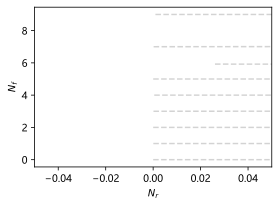

In [9]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
qls = list(range(max_ql))

for ql in qls:
    linestyle = '-'
    if ql in row_indices:
        color = None#'#4999c3'
    else:
        color = 'lightgrey'
        linestyle = '--'
    dressed_idx_arr = overlap_idx_arr[ql]
    photon_num_arr = np.zeros((max_ol))
    fluxonium_num_arr = np.zeros((max_ol))
    for ol in range(max_ol):
        state_after_a = resonator_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        photon_num_arr[ol] = np.sum(state_after_a**2)
        state_after_fluxnonium_a = fluxonium_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        fluxonium_num_arr[ol] = np.sum(state_after_fluxnonium_a**2)

    ax.plot(photon_num_arr,fluxonium_num_arr,label=f'{ql}',color=color,linestyle=linestyle)


ax.set_xlim(0,max_ol-5)
ax.set_xlabel(r'$N_r$')
ax.set_ylabel(r'$N_f$')

plt.tight_layout()
fig.savefig('hybridization.pdf')

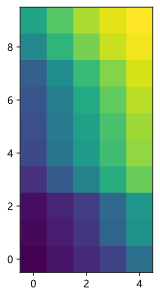

In [10]:
plt.imshow(overlap_idx_arr, origin='lower')

In [11]:
for i in range(max_ql):
    for j in range(max_ol):
        system.product_to_dressed[(i,j)] =  overlap_idx_arr[i,j] 

system.set_sign_multiplier()


In [12]:
w_d = system.evals[system.product_to_dressed[(8,0)]] - system.evals[system.product_to_dressed[(7,0)]]
w_d

1.979220903962224

In [13]:
amp = 0.005
tot_time =1000
tlist = np.linspace(0, tot_time, tot_time)

qls = [0,1,2,7]
initial_states  = [
    qutip.basis(len(system.products_to_keep), system.product_to_dressed[(ql,0)]) for ql in qls
    ]


list_of_systems = []
list_of_kwargs = []
for system, y0 in zip([system for i in range(len(initial_states))], 
                        initial_states):
    list_of_systems.append(system)
    list_of_kwargs.append( {
        'y0':system.truncate_function(y0) ,
        'tlist':tlist,
        'drive_terms':[DriveTerm( 
                            driven_op= system.driven_operator,
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_shape_args={
                                'w_d': w_d ,
                                'amp': amp,
                                't_rise': 20,
                                't_square': tot_time
                            })],
        'e_ops':[system.a_trunc , system.a_trunc.dag()*system.a_trunc],
        'c_ops':c_ops
        })
    

results = run_parallel_ODEsolve_and_post_process_jobs_with_different_systems(
    list_of_systems,
    list_of_kwargs,
    # post_processing = ['pad_back']
)


# import pickle
# with open('sesolve_large_dim_a005.pkl', 'wb') as file:
#     pickle.dump(results, file)


 [**       10%           ] Elapsed 267.02s / Remaining 00:00:40:03

In [86]:
# with open('sesolve_large_dim_a005.pkl', 'rb') as file:
#     results = pickle.load(file)

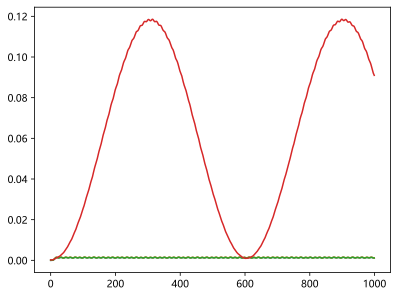

In [88]:
for i,(result,ql) in enumerate((zip(results,qls))):
    plt.plot(results[i].expect[1])
# plt.xlim(0,470)

In [89]:
for i, (result,) in enumerate(zip(results, )):
    result.states_in_product_basis = system.convert_dressed_to_product_vectorized(result.states,
                                                                                    system.products_to_keep,
                                                                                    )